# 0. OpenCV with contrib libraries

In [ ]:
!pip install opencv-contrib-python opencv-python

# 1. Download data 
from [this kaggle dataset](https://www.kaggle.com/pmigdal/alien-vs-predator-images). Unpack it to some folder.

Use the following code to read the data. The data will be stored in the following arrays:
- `X_train`, `X_test` - lists of 2D `np.array`s storing grayscaled images.
- `y_train`, `y_test` - lists of text labels (`alien`, `predator`).

In [3]:
dataset_dir = "datasets/avsp/data"

import cv2
import os

def load_dataset_part(folder):
    result = []
    for i in os.listdir(folder):
        fn = os.path.join(folder, i)
        if os.path.isfile(fn):
            img = cv2.cvtColor(cv2.imread(fn), cv2.COLOR_BGR2GRAY)
            result.append(img)
    return result


def load_dataset(folder, train=True):
    part = 'train' if train else 'validation'
    aliens = load_dataset_part(os.path.join(folder, part, 'alien'))
    predators = load_dataset_part(os.path.join(folder, part, 'predator'))
    X = aliens + predators
    y = ['alien'] * len(aliens) + ['predator'] * len(predators)
    return X, y
    
X_train, y_train = load_dataset(os.path.join(dataset_dir))
X_test, y_test = load_dataset(os.path.join(dataset_dir), train=False)

print(f"Train size {len(X_train)}, Test size {len(X_test)}")

Train size 694, Test size 200


alien


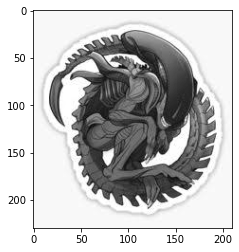

predator


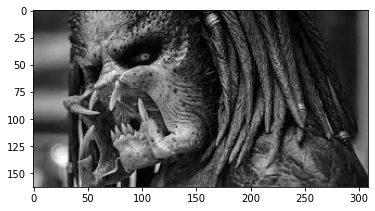

In [4]:
import matplotlib.pyplot as plt

print(y_train[13])
plt.imshow(X_train[13], cmap='gray')
plt.show()

print(y_train[-13])
plt.imshow(X_train[-13], cmap='gray')
plt.show()

# 2. Compute SIFT desciptors
Compute SIFT descriptors for every image. You can use `detectAndCompute(...)` method, please refer to documentation or, e.g. [this tutorial](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html). 

**NB Each image will produce unpredictable (different) number of SIFT vectors. Store them in matrices**

In [18]:
sift = cv2.xfeatures2d.SIFT_create()
X_train_sift = [sift.detectAndCompute(img, None)[1] for img in X_train]
X_test_sift = [sift.detectAndCompute(img, None)[1] for img in X_test]

Sample vector 0 of 13th image:

In [80]:
print(X_train_sift[13][0])

[  0.   0.   0.   3.  24.   2.   0.   0.  15.   0.   0.  13. 105.   3.
   0.   2. 139.   1.   0.   2.  17.   0.   0.  10.  19.   1.   0.  38.
 163.   0.   0.   1.   0.   0.   0.   3.  41.   2.   0.   0.  20.   1.
   0.   9. 130.   2.   0.   3. 163.   4.   0.   1.  19.   1.   0.  12.
  21.   0.   0.  15. 163.   0.   0.   1.   0.   1.   0.   3.  48.   2.
   0.   0.  23.   3.   0.  10. 127.   2.   0.   1. 163.  10.   0.   2.
  19.   1.   0.   8.  19.   1.   0.   3. 163.   8.   0.   1.   0.   1.
   0.   1.  30.   5.   0.   0.  12.   4.   0.   1.  95.  21.   0.   0.
 123.  33.   0.   1.  16.   4.   0.   0.  20.   5.   0.   0. 163.  25.
   0.   0.]


In [81]:
Counter(y_train)

Counter({'alien': 347, 'predator': 347})

# 3. Organize these vectors in the index (somehow)

I personally used the following strategy:
- I numerate all vectors. `labels` array stores image index for a vector.
- Vector itself is a key, vector's index `c` thoughout all the vectors is value. 
- Then, `labels[c]` will return image index.
- I query the index with a vector `v` and recieve `c`.
- Thus, `y_train[labels[c]]` is a class of the images, described by the vector `v`.

In [138]:
from sklearn.decomposition import PCA

n_comp = 35

flatted = [v for i in X_train_sift for v in i]


p = PCA(n_comp)
p.fit(flatted)

PCA(n_components=35)

In [139]:
print(sum(p.explained_variance_ratio_))

0.8138478843712711


In [148]:
from tqdm import tqdm
from annoy import AnnoyIndex
import numpy as np
index = AnnoyIndex(n_comp, 'euclidean')

labels = []
for i, v in enumerate(X_train_sift):
    for desc in p.transform(v):
        labels.append(i)
        index.add_item(len(labels) - 1, desc)
index.build(10)

True

# 4. Classification

Implement the best possible classifier function to your knowledge. Utilize all the data from the index and datasets. E.g.
- if you set `include_distances=True` in Annoy search, it will also add distances in search results.
- How many times each particular image was present in matches?
- What about k-nn approach?
- What about training a classifier based on vectors?
- How about filtering out some useless vectors?
- and so on...

In [149]:
from collections import Counter

def clf(vecs, index, labels, classes, n=50):
    # my very simple classifier lived here. Can you do better?
    # write your code and change the method signature in needed
    indices = []
    vecs = p.transform(vecs)
    for v in vecs:
        indices.extend(index.get_nns_by_vector(v, n, include_distances=True))
        
    dist = [classes[labels[idx]] for idx in indices[0]]
    
    
    A = 0
    P = 0
    for cls, distance in zip(dist, indices[1]):
        if cls == "alien":
            A += 1/(distance + 1)
        else:
            P += 1/(distance + 1)
    return "alien" if A > P else "predator"

## Test
Use these blocks to test your results. Pay attention to `accuracy` value. For me this is `0.74`. You can definitely do better :)

In [150]:
predictions = []
for sample in tqdm(X_test_sift):
    predictions.append(clf(sample, index, labels, y_train))

100%|██████████| 200/200 [00:08<00:00, 22.50it/s]


In [151]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       alien       0.62      0.52      0.57       100
    predator       0.59      0.68      0.63       100

    accuracy                           0.60       200
   macro avg       0.60      0.60      0.60       200
weighted avg       0.60      0.60      0.60       200



## Submission
Show your implementation and classification report to your TA. Observe your results [by the link](https://docs.google.com/spreadsheets/d/1fMPx7_JwKwuds82EYJSmKnIeOM4JLG0QEeXB_6NG2x8/edit?usp=sharing).

**NB SUBMIT YOUR SOLUTIONS WITH CLASSIFICATION REPORT TO MOODLE BY MIDNIGHT**